credit to: USC CSCI566  Deep Learning and its Applications

参数的初始化问题是很重要的
以一层Linear层为例
(使用augmented notation,也就是向量$\underline{x} = [x_0, x_1, \ldots, x_n, b]$, b is bias)

$Y = \underline{w}^T \cdot \underline{x}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x = np.ones(100)
w = np.zeros(100)
Y = w.T @ x
print(Y)

0.0


也就是说如果weight为0的话，无论$\underline{x}$的值是多少，Y的值都不会发生变化
那么以下讨论三种可能的weight initialization 方法

1. small random variables
$\underline{w} \sim \mathcal{N}(\mu,\sigma^2)$

In [3]:
np.random.seed(2025)
w = 0.01 * np.random.randn(100)
print(w.shape,w.min(),w.max(),w.mean())
Y = w.T@x
print(Y)

(100,) -0.02211669195299307 0.021469865732856207 -0.0014986725019622235
-0.14986725019622238


看似是ok的，但是如果在一个包含activation function的比较深的神经网络中，就可能会有比较严重的问题:

一个六层的网络，
activation function为 $tanh$
$h_0 = x \in \mathbb{R}^{16 \times 100}\\
 W_i \in \mathbb{R}^{100 \times 100} \\
 h_i = \tanh(h_{i-1} \cdot W_i)
$

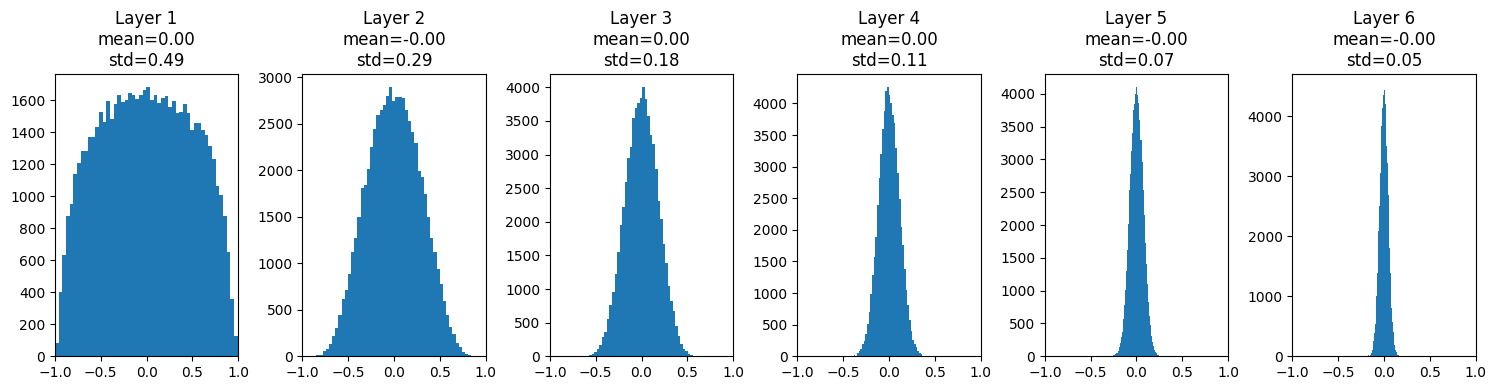

In [4]:
dims = [4096] * 7
hs = [] # store history
x = np.random.randn(16,dims[0])
for Din,Dout in zip(dims[:-1],dims[1:]):
    w = 0.01 * np.random.randn(Din,Dout)
    x = np.tanh(x@w.T)
    hs.append(x)
def simple_visualize(hs):
    fig, axs = plt.subplots(1, 6, figsize=(15, 4))
    
    for i in range(len(hs)):
        layer_data = hs[i].flatten()
        mean = np.mean(layer_data)
        std = np.std(layer_data)
        
        axs[i].hist(layer_data, bins=50, color='#1f77b4')
        axs[i].set_title(f"Layer {i+1}\nmean={mean:.2f}\nstd={std:.2f}")
        axs[i].set_xlim(-1, 1)
    
    plt.tight_layout()
    plt.show()

# 调用简化的可视化函数
simple_visualize(hs)

能够看到后续的activations会趋于0，模型无法学习

2. Xavier
之前造成activation趋于0的原因是因为方差的减小，使得后续的activation越来越集中
那就想一个办法，使得方差不再集中，让输入与输出的方差保持不变:
$W \sim \mathcal{N}(\mu, \sigma^2) \leftarrow Var(W) = \frac{1}{n_{in}}$



简单推导为什么这样就可以使得方差不再集中：
已知
$$
\begin{align}
W_{ji} &\sim \mathcal{N}\left(0,\frac{1}{n_{in}}\right), \quad x_i \sim \mathcal{N}(\mu, \sigma^2), \quad \text{输入}~x_i~\text{和}~w_{ji}~\text{是iid.的} \\[10pt]
\text{那么}~z_j &= \sum_{i=1}^{n_{in}} W_{ji} \cdot x_i + b_j \quad (b_j~\text{是bias，如果使用augmented notation可省略}) \\[10pt]
\text{计算方差}~\text{Var}(z_j) &= \text{Var}\left(\sum_{i=1}^{n_{in}} W_{ji}\cdot x_i \right) \\
&\overset{\text{iid}}{=} \sum_{i=1}^{n_{in}} \text{Var}(w_{ji} \cdot x_i) \\
&= \sum_{i=1}^{n_{in}} \mathbb{E}[W_{ji}^2]\mathbb{E}[x_i^2] - (\mathbb{E}[W_{ji}]\mathbb{E}[x_i])^2 \\
&\overset{\mathbb{E}=0}{=} \sum_{i=1}^{n_{in}} \mathbb{E}[W_{ji}^2]\mathbb{E}[x_i^2] \\
&= \sum_{i=1}^{n_{in}}\text{Var}(w_{ji}) \cdot \text{Var}(x_i) \\
&= n_{in} \cdot \frac{1}{n_{in}} \cdot \sigma^2 \\
&= \sigma^2 \\[10pt]
\text{对于tanh激活函数，在0附近有}~\tanh(z) &\approx z\\
\text{所以}~\text{Var}(\tanh(z_j)) &\approx \text{Var}(z_j) = \sigma^2
\end{align}
$$

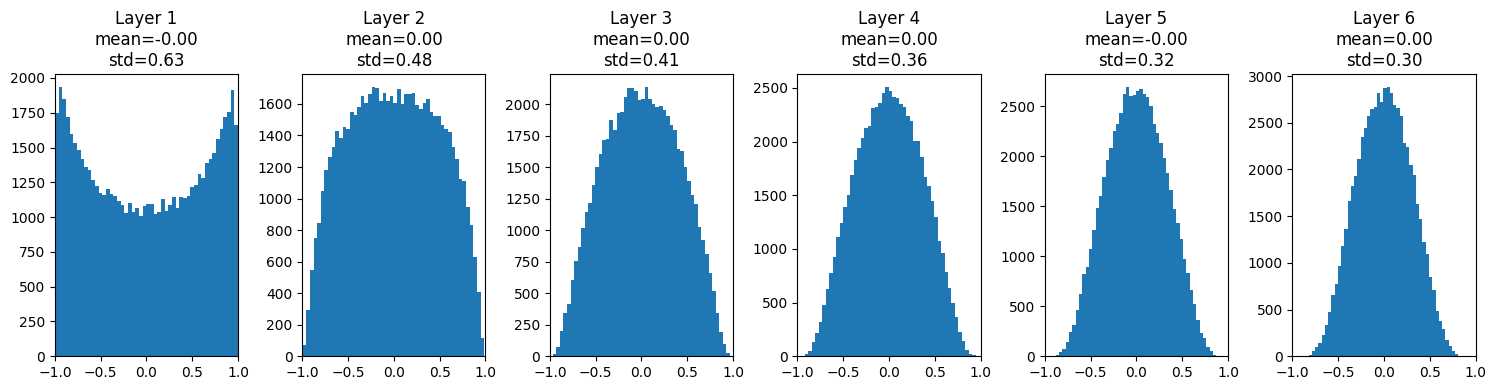

In [5]:
dims = [4096] * 7
hs = [] # store history
x = np.random.randn(16,dims[0])
for Din,Dout in zip(dims[:-1],dims[1:]):
    w = np.random.randn(Din,Dout)/np.sqrt(Din)
    x = np.tanh(x@w.T)
    hs.append(x)
simple_visualize(hs)

那么针对早期使用tanh作为activation的问题解决了，那么这种方法对于relu来说呢


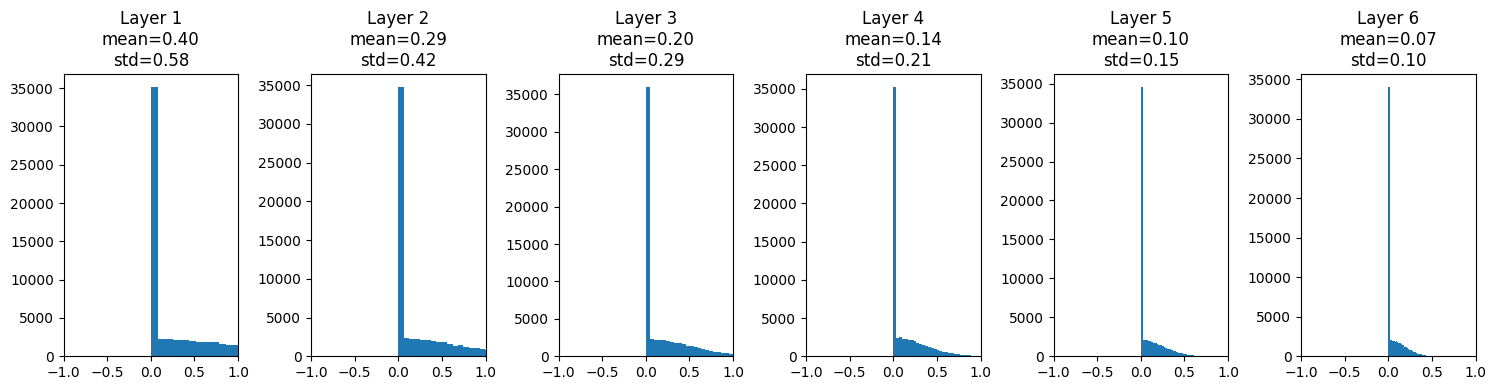

In [6]:
dims = [4096] * 7
hs = [] # store history
x = np.random.randn(16,dims[0])
for Din,Dout in zip(dims[:-1],dims[1:]):
    #std = sqrt(np.sqrt(D_in))
    w = np.random.randn(Din,Dout)/np.sqrt(Din)
    x = np.maximum(0,x@w.T)
    hs.append(x)
simple_visualize(hs)

可以看到数据越来越往中间集中，一样的方法可以修正：RELU截断了数据的一半，那就乘以2补回来

$$
\begin{gather}
\text{对于ReLU激活函数:}\\[10pt]
ReLU(z) = \max(0, z)\\[10pt]
\text{假设:}\\[10pt]
W_{ji} \sim \mathcal{N}(0, \sigma_w^2)\\[10pt]
E[x_i] = 0, \quad Var(x_i) = \sigma_x^2\\[10pt]
\text{线性变换:}\\[10pt]
z_j = \sum_{i=1}^{n_{in}} W_{ji}x_i + b_j\\[10pt]
\text{计算线性输出的方差:}\\[10pt]
Var(z_j) = \sum_{i=1}^{n_{in}} Var(W_{ji}x_i)\\[10pt]
= \sum_{i=1}^{n_{in}} \sigma_w^2 \cdot \sigma_x^2\\[10pt]
= n_{in} \cdot \sigma_w^2 \cdot \sigma_x^2\\[10pt]
\text{对于ReLU激活:}\\[10pt]
\text{由于ReLU将负值置为0，约有一半的输入被"截断"，方差减半:}\\[10pt]
Var(ReLU(z_j)) \approx \frac{1}{2} Var(z_j)\\[10pt]
= \frac{1}{2} \cdot n_{in} \cdot \sigma_w^2 \cdot \sigma_x^2\\[10pt]
\text{为了保持方差不变 $Var(ReLU(z_j)) = \sigma_x^2$，需要:}\\[10pt]
\frac{1}{2} \cdot n_{in} \cdot \sigma_w^2 \cdot \sigma_x^2 = \sigma_x^2\\[10pt]
\text{解得:}\\[10pt]
\sigma_w^2 = \frac{2}{n_{in}}\\[10pt]
\text{因此:}\\[10pt]
\sigma_w = \sqrt{\frac{2}{n_{in}}}\\[10pt]
\text{这就是Kaiming初始化的标准差公式}
\end{gather}
$$


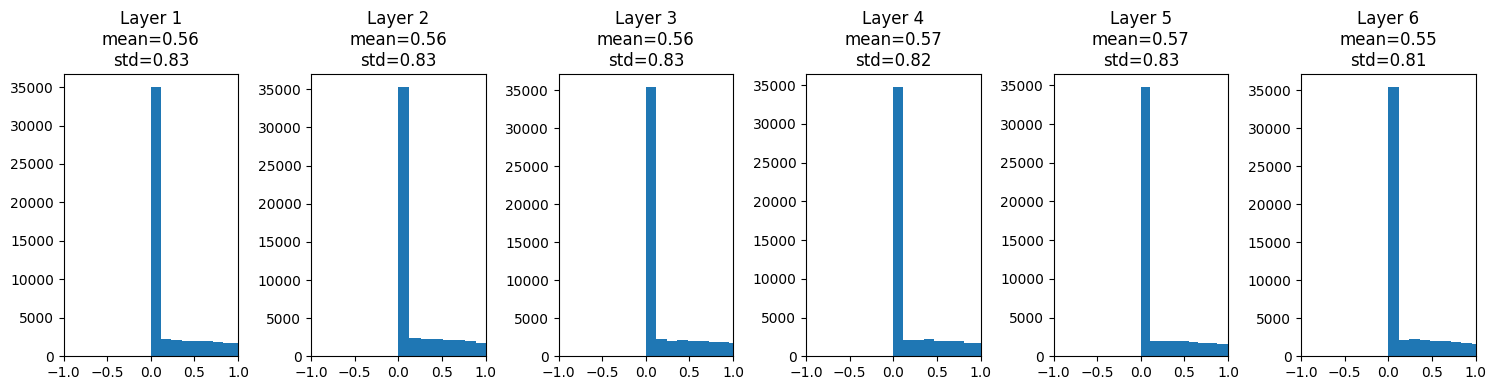

In [7]:
dims = [4096] * 7
hs = [] # store history
x = np.random.randn(16,dims[0])
for Din,Dout in zip(dims[:-1],dims[1:]):
    #std = sqrt(np.sqrt(D_in))
    w = np.random.randn(Din,Dout)*np.sqrt(2/Din) 
    x = np.maximum(0,x@w.T)
    hs.append(x)
simple_visualize(hs)